# Introduction
We will produce a 5 percent Value-at-Risk (VaR) estimate for the S&P500. Our model assumes the variance of returns follows a $GARCH(1, 1)$ model. The orders of the GARCH model will not be fit to the data; we refer the reader to the literature which states $GARCH(1, 1)$ models tend to perform best out-of-sample for financial data. 

We suppose the return at time $t$ of the S&P500
$$
r_t \sim{\mathcal{N}(0, \sigma_t^2)}
$$
where
$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma_{t-1}^2.
$$
This implies $VaR_t$ is about
$$
1.645\sigma_t.
$$
However, due to the propensity for VaR exceptions to "bunch," we will increase $VaR_t$ for 40 days after an exception occurs.

The date range for this exercise is 2008 to 2020, inclusive, and the data are at the daily frequency. We chose this range because it includes the financial crisis and the market downturn in March of 2020. We will see that slightly more than 5 percent of days are exceptions. This seems reasonable even assuming the long-term fraction of exceptions each year is only 5 percent because of the time-window we considered. We obtained our data from Yahoo Finance.

# Packages and Setup

In [75]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import os
os.chdir("/Users/charlesrambo/Desktop")

To calculate returns, we used the adjusted closing price of the SP&P500 because we did not want a VaR exception to be triggered due to a change in the index, a dividend payment, or a stock split. 

In [76]:
# Load S&P500 data
sp500 = pd.read_csv("sp500.csv")

# Convert data column to date object
sp500['Date'] = pd.to_datetime(sp500['Date'], format = '%Y-%m-%d')

# Calculate returns
sp500['Ret'] = (sp500['Adj Close'] - sp500['Adj Close'].shift(1))/sp500['Adj Close'].shift(1)

# Only use the two most informative columns
sp500 = sp500[['Date', 'Ret']]

# Fill missing values with 0
sp500['Ret'] = sp500['Ret'].fillna(0)

# Create year column
sp500['year'] = sp500['Date'].dt.year

# Only consider observations from the year 2008 to 2020, inclusive
sp500 = sp500.loc[(sp500['year'] >= 2008) & (sp500['year'] < 2021), :].reset_index(drop = True)

sp500.head()

,Date,Ret,year
0,2008-01-02,-0.014438,2008
1,2008-01-03,0.000000,2008
2,2008-01-04,-0.024552,2008
3,2008-01-07,0.003223,2008
4,2008-01-08,-0.018352,2008


To obtain the parameters $\omega$, $\alpha$, and $\beta$ in the model
$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma_{t-1}^2
$$
we used MLE parameters using data from time $t - 126$ to $t - 1$. Since our optimizer minimizes, we negate the output of the likelihood function. We also define the function so that 
$$
\alpha + \beta < 1\quad\text{and}\quad \omega, \alpha, \beta \geq 0.
$$

In [77]:
def likelihood(x, date):
    
    likelihood = 0
    
    # Need the sum of alpha and beta to be less than 1 and all terms to be positive
    if (np.sum(x[1:]) > 1) | (np.min(x) < 0) :
           
            return np.Inf
            
    else:
        
        # Calculate observation range
        stop = np.sum(sp500['Date'] < date)
        
        # Consider observations 126 days before; expanding window when not enough observations
        start = np.max([stop - 126, 0])
        
        # Initialize sigma^2
        sigma2 = sp500.loc[start, 'Ret']**2 
    
        # Initialize epsilon^2
        epsilon2 = sp500.loc[start, 'Ret']**2 
        
        # Start is included and stop is excluded in Python
        for i in range(start, stop):
    
            sigma2 = x[0] + x[1] * epsilon2 + x[2] * sigma2
        
            epsilon2 = sp500.loc[i, 'Ret']**2 
        
            # Multiply likelihood value by pdf evaluate at new value and parameter
            likelihood *= stats.norm.pdf(np.sqrt(epsilon2), loc = 0, scale = np.sqrt(sigma2))
     
        # Negative because optimizer minimizes
        return -likelihood


Since we assume $r_t\sim{\mathcal{N}(0, \sigma_t)}$, at the time $t$ the 5 percent Value-at-Risk
$$
VaR_t = \Phi^{-1}(0.05)\cdot \sigma_t,
$$
where $\Phi$ is the CDF of the standard normal distribution.

In [78]:
# Initialize sigma^2 for first day
sigma2 = 2 * 10**-5

# Initialize VaR column
sp500['VaR'] = 0

# Calculate VaR for first day
sp500.loc[0, 'VaR'] = np.sqrt(sigma2)

# Initilize optimizer; after first iteration the previous iteration value will be used for initialization 
x = [2 * 10**-5 , 0.40, 0.40]

for i in sp500.index[1:]:
    
    x = opt.minimize(lambda x: likelihood(x, sp500.loc[i, 'Date']), x0 = x, method = 'Nelder-Mead')['x']
    
    sigma2 = x[0] + x[1] * sp500.loc[i - 1, 'Ret']**2 + x[2] * sigma2
    
    # Get sd for VaR calculation; true VaR will be computed later
    sp500.loc[i, 'VaR'] = np.sqrt(sigma2)

# Z is about -1.645
Z = stats.norm.ppf(0.05)

# Multiple by -Z to obtain VaR
sp500['VaR'] = 0 - Z * sp500['VaR']

# Obtain days when there is an exception
sp500['exception'] = 0 - sp500['VaR'] > sp500['Ret']

Because of the tendency for Value-at-Risk exceptions to "bunch," we will increase the Value-at-Risk for the 40 days following an exception. We will use data from year $y$ to calculate a scalar to increase Value-at-Risk for all years greater than $y$. We emphasize that we only scale the Value-at-Risk up for the days after the first exception; if we included the first exception then there would be a look-ahead bias.

In [79]:
# Calculate function to do scaling
def rescale_VaR(data):
    
    # Get unique years
    years = np.unique(data['year'])
    
    for year in years:
        
        # Break data into train and test
        
        # Train only uses year y
        train = data.loc[data['year'] == year, :]
        
        # Test used all years > y
        test = data.loc[data['year'] > year, :]

        # Initilaize exceptions after first at 25%
        red_alert_excp = 0.25
        
        # Initialize count of iterations of while-loop
        n = 0 
        
        # Stop while-loop if red_alter_excp is close enough to 5% or over five iterations 
        while((np.abs(red_alert_excp - 0.05) > 10**-3) & (n < 5)):

            # Find number of exceptions
            train['exception'] = 0 - train['VaR'] > train['Ret']

            # Create flag1
            train['flag1'] = train['exception']
    
            # Replace everythin except exceptions with nan
            train.loc[train['flag1'] != True, 'flag1'] = np.nan
    
            # Forward fill for 40 days
            train['flag1'] = train['flag1'].ffill(limit = 40)
    
            # Replace all nan values with False
            train.loc[train['flag1'].isna(), 'flag1'] = False
    
            # Check to see if first exception
            train['flag2'] = train['flag1'].shift(1) != train['flag1']
    
            # If first exception then change flag1 to false; can't scale that one up without look-ahead bias
            train.loc[(train['flag1'] == True) * (train['flag2'] == True), 'flag1'] = False
      
            # Calculate how far we are from larget of 5%
            error = red_alert_excp - 0.05
    
            # Calculate scalar
            scalar = 1 + error
 
            # Scale VaR
            train.loc[train['flag1'] == True, 'VaR'] = scalar * train.loc[train['flag1'] == True, 'VaR']
        
            # Calulate new number of exceptions
            train['exception'] = 0 - train['VaR'] > train['Ret']

            # Calculate fraction of days after exception that we get another exception
            red_alert_excp = train.loc[train['flag1'] == True, 'exception'].mean()
    
            n += 1
        
        # Do the same thing for test df
        test['flag1'] = test['exception']

        test.loc[test['flag1'] == False, 'flag1'] = np.nan

        test['flag1'] = test['flag1'].ffill(limit = 40)

        test.loc[test['flag1'].isna(), 'flag1'] = False

        test['flag2'] = test['flag1'].shift(1) != test['flag1']
    
        test.loc[(test['flag1'] == True) * (test['flag2'] == True), 'flag1'] = False

        test.loc[test['flag1'] == True, 'VaR'] = scalar * test.loc[test['flag1'] == True, 'VaR']
        
        test['exception'] = 0 - test['VaR'] > test['Ret']

        test.drop(['flag1', 'flag2'], axis = 1, inplace = True)

        # Replace data df with corresponding observations of test df
        data.loc[data['year'] > year, :] = test
        
    return data
    
sp500 = rescale_VaR(sp500)

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

The fraction of days which are exceptions is about 6.7 percent. This is larger than our target of 5 percent. However, our time range includes two extraordinarily larger downturns. As a result, if only 5 percent of days were exceptions, then it may imply our Value-at-Risk calculation is too conservative and the long-term fraction of exceptions is--in fact--less than 5 percent.

In [80]:
sp500['frac_excp'] = sp500.groupby('year')['exception'].transform('mean')

sp500['frac_excp'].describe()

count    3274.000000
mean        0.064447
std         0.029712
min         0.015936
25%         0.040000
50%         0.067460
75%         0.086957
max         0.130435
Name: frac_excp, dtype: float64

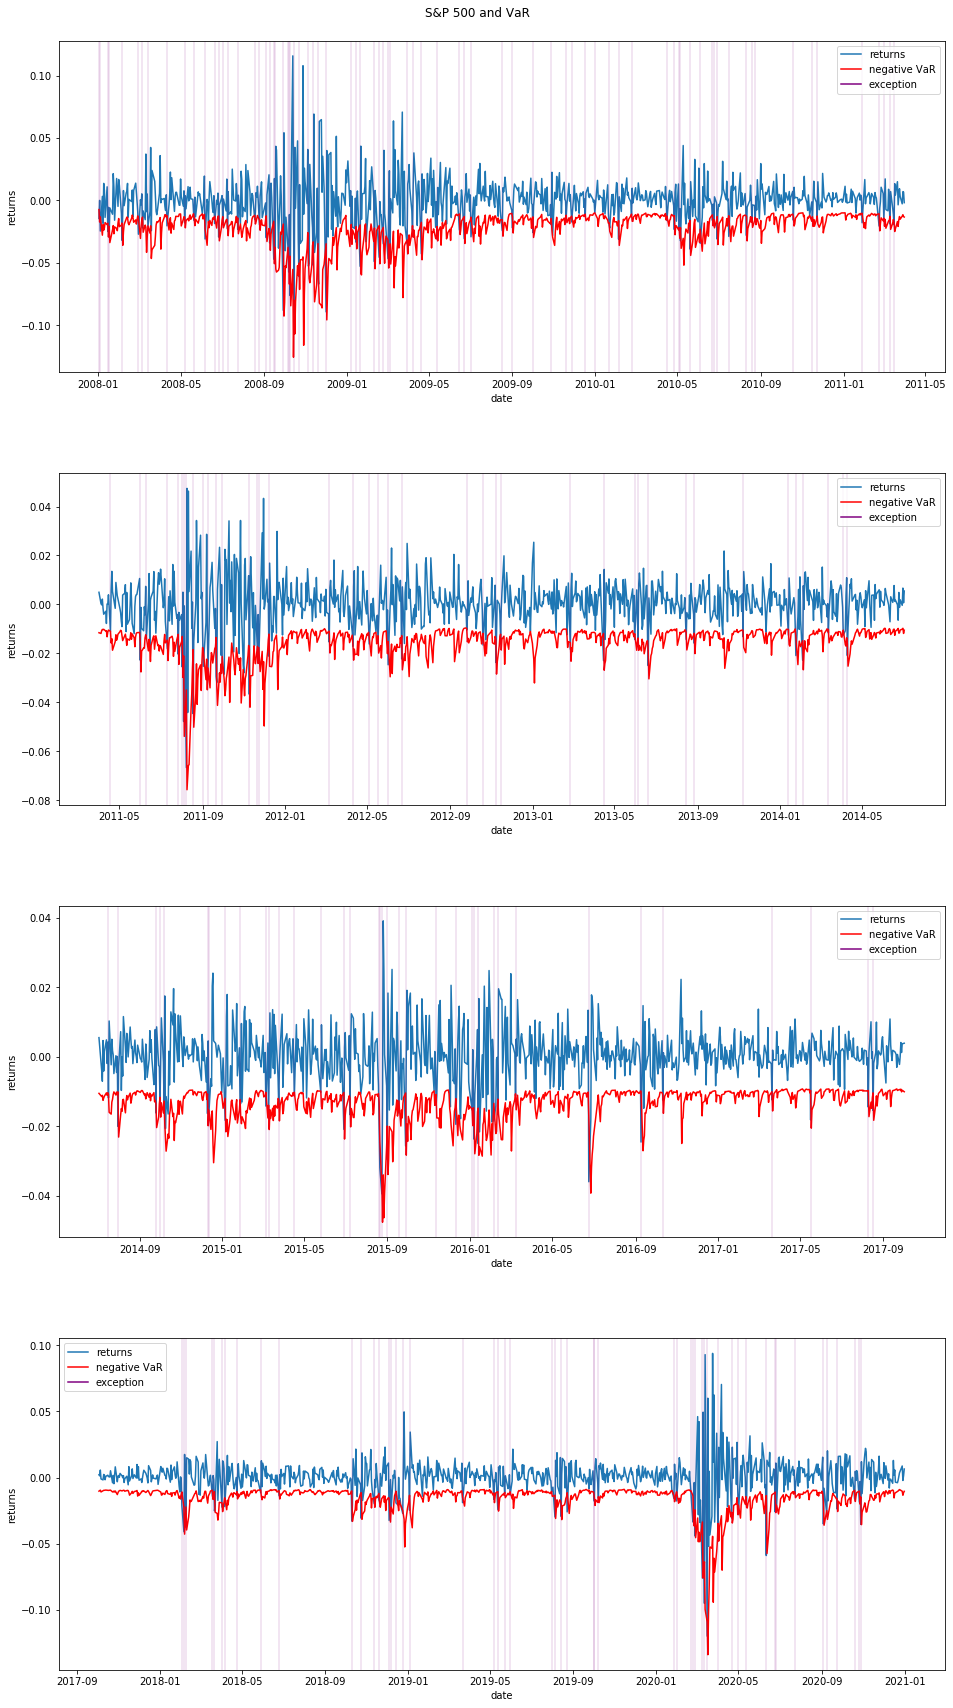

In [83]:
# Number of rows
k = 4

# Plot returns
n = len(sp500)/k

fig, ax = plt.subplots(k, 1, figsize = (15,25))

for i in range(k):

    ax[i].plot(sp500.loc[(i * n):(i * n + n), 'Date'], sp500.loc[(i * n):(i * n + n), 'Ret'], label = 'returns')
    ax[i].plot(sp500.loc[(i * n):(i * n + n), 'Date'], 0 - sp500.loc[(i * n):(i * n + n), 'VaR'], color = 'red', 
               label = 'negative VaR')
    ax[i].plot([], [], label = "exception", color = 'purple')
    ax[i].set_xlabel('date') 
    ax[i].set_ylabel('returns') 
    ax[i].legend()
    
    for j in range(int(i * n), int(i * n + n)):

        if sp500.loc[j, 'exception'] == True:
            
            ax[i].axvline(x = sp500.loc[j, 'Date'], color = 'purple', linewidth = 0.2)
            
fig.suptitle('S&P 500 and VaR')
plt.tight_layout(pad = 7)

plt.show()